In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

C:\Users\thoma\AppData\Local\Temp\ipykernel_11880\4077030368.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Analyse exploratoire des données**

In [2]:
train = pd.read_csv('train.csv')
train.info()
train.describe()
test = pd.read_csv('test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

La fonction describe() permet de voir les statistiques descriptives des données. Notre jeu de données comprend une liste de 1460 maisons. On remarque que pour notre variable cible SalePrice, la moyenne est de 180 921,2$ pour un minimum de 34 900$ et un maximum de 755 000$. La superficie du terrain LotArea varie considérablement, avec une moyenne d'environ 10 516 pieds carrés. Cela montre la diversité des propriétés en termes de taille de terrain. La qualité générale des matériaux et de la finition de la maison est évaluée sur une échelle de 1 à 10, avec une moyenne d'environ 6, ce qui suggère que la plupart des maisons sont de qualité au-dessus de la moyenne. YearBuilt et YearRemodAdd : Ces colonnes indiquent respectivement l'année de construction et l'année de la dernière rénovation des maisons. La moyenne de l'année de construction est de 1971, ce qui implique que le jeu de données inclut principalement des maisons construites dans la seconde moitié du 20ème siècle.

In [3]:
valeurs_manquantes = train.isnull().sum()
pourcentage_va = (train.isnull().sum() / len(train)) * 100

missing_df = pd.DataFrame({'Nombre de valeurs manquantes': valeurs_manquantes, 'Pourcentage': pourcentage_va})
missing_df = missing_df[missing_df['Nombre de valeurs manquantes'] > 0].sort_values(by='Pourcentage', ascending=False)

missing_df

,Nombre de valeurs manquantes,Pourcentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Face à la présence de nombreuses valeurs manquantes dans certaines colonnes, nous avons envisagé deux stratégies pour y remédier. La première stratégie consiste à éliminer les colonnes présentant un nombre élevé de valeurs manquantes. La seconde stratégie vise à remplacer les valeurs manquantes par la médiane pour les variables quantitatives et, pour les variables qualitatives, à les convertir en catégories, traitant ainsi les valeurs manquantes comme une catégorie distincte. Par exemple, pour une colonne comme PoolQC, l'absence de piscine constitue une information utile en soi. Nous avons opté pour la seconde stratégie afin de préserver un maximum d'informations.

In [4]:
quanti_cols = train.select_dtypes(include = ['int64', 'float64']).columns
quali_cols  = train.select_dtypes(include = ['object']).columns

imputer_quant = SimpleImputer(strategy = 'median')
train[quanti_cols] = imputer_quant.fit_transform(train[quanti_cols])

# On crée une nouvelle catégorie 'None' pour les valeurs manquantes des variables qualitatives
for col in quali_cols:
    train[col] = train[col].fillna('None')

# Contrôle de cohérence
train.isnull().sum().sum()

0

In [5]:
# Appliquer l'encodage one-hot aux variables catégorielles
train_encoded = pd.get_dummies(train, drop_first=True)

# Identifier les colonnes booléennes
bool_cols = train_encoded.select_dtypes(include='bool').columns

# Convertir les colonnes booléennes en 0 et 1
for col in bool_cols:
    train_encoded[col] = train_encoded[col].astype(int)

# Afficher les nouvelles dimensions du DataFrame après encodage
new_shape = train_encoded.shape

# Afficher un aperçu des nouvelles colonnes créées par l'encodage one-hot
train_encoded.head(), new_shape

(    Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
 0  1.0        60.0         65.0   8450.0          7.0          5.0     2003.0   
 1  2.0        20.0         80.0   9600.0          6.0          8.0     1976.0   
 2  3.0        60.0         68.0  11250.0          7.0          5.0     2001.0   
 3  4.0        70.0         60.0   9550.0          7.0          5.0     1915.0   
 4  5.0        60.0         84.0  14260.0          8.0          5.0     2000.0   
 
    YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
 0        2003.0       196.0       706.0  ...               0               0   
 1        1976.0         0.0       978.0  ...               0               0   
 2        2002.0       162.0       486.0  ...               0               0   
 3        1970.0         0.0       216.0  ...               0               0   
 4        2000.0       350.0       655.0  ...               0               0   
 
    SaleType_New  

In [7]:
# On applique la même transformation au jeu de test

# Séparation des variables quantitatives et qualitatives
quanti_cols_test = test.select_dtypes(include=['int64', 'float64']).columns
quali_cols_test = test.select_dtypes(include=['object']).columns

# Imputation des valeurs manquantes pour les variables quantitatives avec la médiane
imputer_quant_test = SimpleImputer(strategy='median')
test[quanti_cols_test] = imputer_quant_test.fit_transform(test[quanti_cols_test])

# Création d'une nouvelle catégorie 'None' pour les valeurs manquantes des variables qualitatives
for col in quali_cols_test:
    test[col] = test[col].fillna('None')

# Vérification de l'absence de valeurs manquantes
missing_values_after_imputation = test.isnull().sum().sum()

# Application de l'encodage one-hot aux variables catégorielles
test_encoded = pd.get_dummies(test, drop_first=True)

# Identification des colonnes booléennes
bool_cols_test = test_encoded.select_dtypes(include='bool').columns

# Conversion des colonnes booléennes en 0 et 1
for col in bool_cols_test:
    test_encoded[col] = test_encoded[col].astype(int)

# Nouvelles dimensions du DataFrame après encodage
new_shape_test = test_encoded.shape

missing_values_after_imputation, new_shape_test, test_encoded.head()

(0,
 (1459, 249),
        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
 0  1461.0        20.0         80.0  11622.0          5.0          6.0   
 1  1462.0        20.0         81.0  14267.0          6.0          6.0   
 2  1463.0        60.0         74.0  13830.0          5.0          5.0   
 3  1464.0        60.0         78.0   9978.0          6.0          6.0   
 4  1465.0       120.0         43.0   5005.0          8.0          5.0   
 
    YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
 0     1961.0        1961.0         0.0       468.0  ...               0   
 1     1958.0        1958.0       108.0       923.0  ...               0   
 2     1997.0        1998.0         0.0       791.0  ...               0   
 3     1998.0        1998.0        20.0       602.0  ...               0   
 4     1992.0        1992.0         0.0       263.0  ...               0   
 
    SaleType_New  SaleType_None  SaleType_Oth  SaleType_WD  \
 0             0

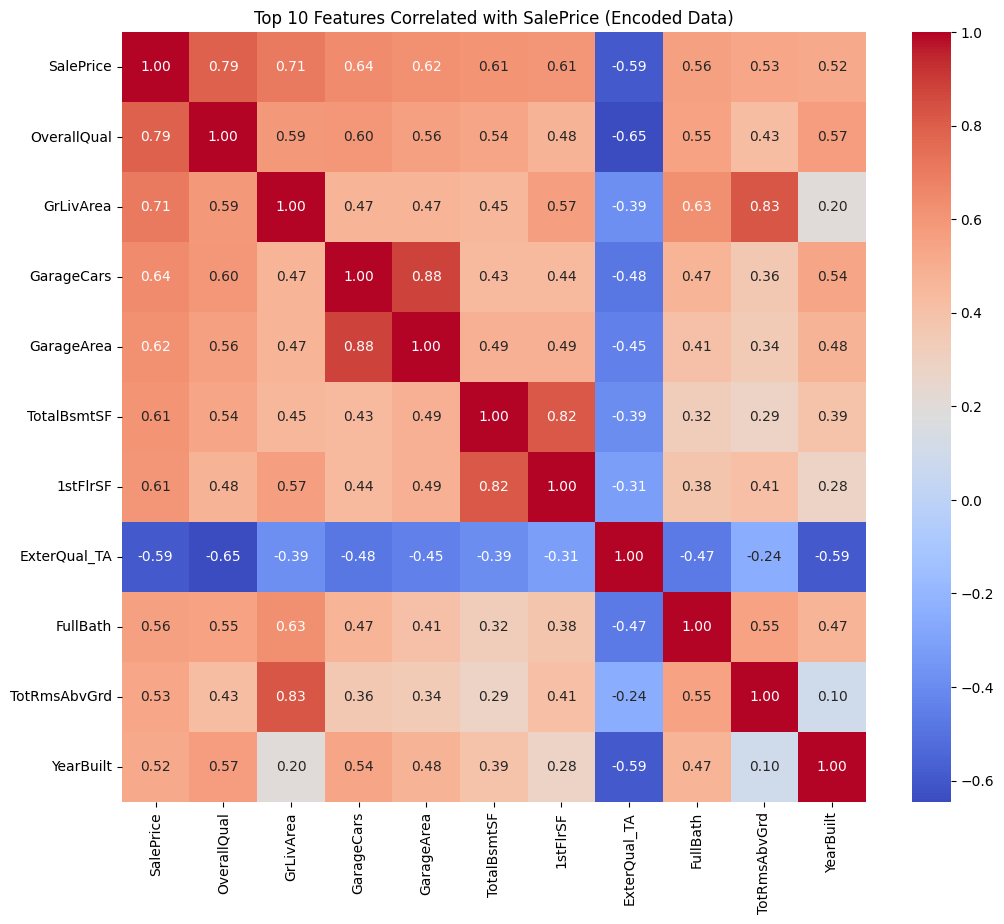

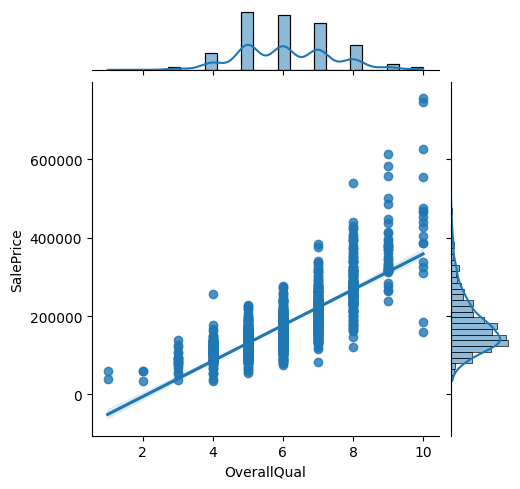

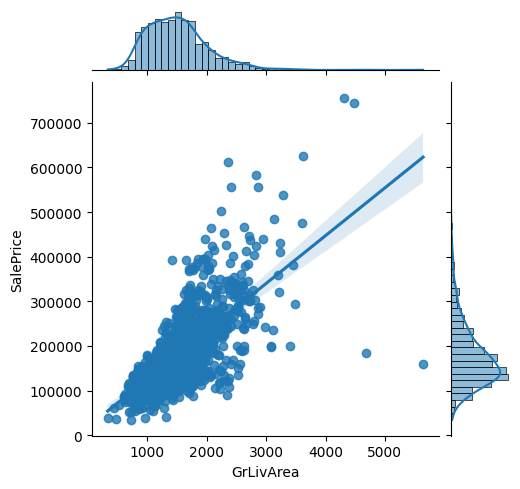

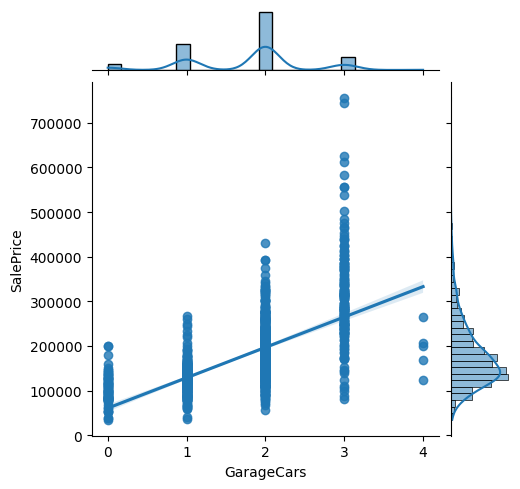

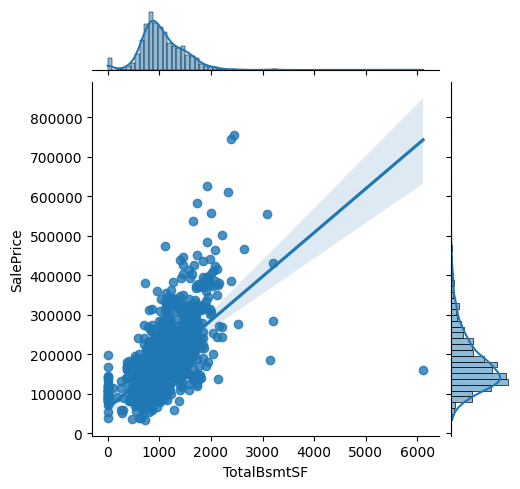

In [8]:
# Recalculer la matrice de corrélation sur le DataFrame encodé
correlation_matrix_encoded = train_encoded.corr()

# Sélectionner les 10 caractéristiques les plus corrélées avec SalePrice dans le DataFrame encodé
top_correlated_features_encoded = correlation_matrix_encoded['SalePrice'].sort_values(key=abs, ascending=False).head(11).index

# Calculer la matrice de corrélation pour ces caractéristiques encodées
top_corr_matrix_encoded = train_encoded[top_correlated_features_encoded].corr()

# Afficher la matrice de corrélation pour les caractéristiques encodées avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix_encoded, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 Features Correlated with SalePrice (Encoded Data)")
plt.show()

pairs_to_plot = [('OverallQual', 'SalePrice'), ('GrLivArea', 'SalePrice'), ('GarageCars', 'SalePrice'), ('TotalBsmtSF', 'SalePrice')]

# Générer à nouveau les nuages de points pour ces paires
for x, y in pairs_to_plot:
    sns.jointplot(x = x, y = y, data = train_encoded, kind = "reg", height = 5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [9]:
# Traitement des valeurs aberrantes (IQR score)
"""
outlier_stats = {}
selected_columns = ['SalePrice', 'GrLivArea', 'TotalBsmtSF']

for column in selected_columns:
    Q1 = train_encoded[column].quantile(0.25)
    Q3 = train_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Compter le nombre de valeurs aberrantes
    outliers_count = ((train_encoded[column] < lower_bound) | (train_encoded[column] > upper_bound)).sum()
    outlier_stats[column] = {'Lower Bound': lower_bound, 'Upper Bound': upper_bound, 'Outliers Count': outliers_count}

outlier_stats
"""

"\noutlier_stats = {}\nselected_columns = ['SalePrice', 'GrLivArea', 'TotalBsmtSF']\n\nfor column in selected_columns:\n    Q1 = train_encoded[column].quantile(0.25)\n    Q3 = train_encoded[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    \n    # Compter le nombre de valeurs aberrantes\n    outliers_count = ((train_encoded[column] < lower_bound) | (train_encoded[column] > upper_bound)).sum()\n    outlier_stats[column] = {'Lower Bound': lower_bound, 'Upper Bound': upper_bound, 'Outliers Count': outliers_count}\n\noutlier_stats\n"

**Modèle de regression simple**

On va récupérer les variables les plus importantes d'après le coefficient de corrélation. On fait ensuite une regression simple sur les 3 variables les plus corrélées avec SalePrice.

In [10]:
# Calcul de la matrice de corrélation
correlation_matrix = train_encoded.corr()

# Trouver les 3 variables les plus corrélées avec SalePrice
top_correlated_variables = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:4]

top_correlated_variables

# Préparation des résultats
results = []

for variable in top_correlated_variables.index:
    # Préparation des données
    X = train_encoded[[variable]]
    y = train_encoded['SalePrice']
    
    # Modèle de régression linéaire
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédictions
    predictions = model.predict(X)
    
    # Calcul du RMSE et du R²
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    
    # Stockage des résultats
    results.append({
        'Variable': variable,
        'Coefficient': model.coef_[0],
        'RMSE': rmse,
        'R²': r2
    })

# Conversion des résultats en DataFrame pour une meilleure lisibilité
results_df = pd.DataFrame(results)

results_df

,Variable,Coefficient,RMSE,R²
0,OverallQual,45435.802593,48589.447121,0.625652
1,GrLivArea,107.130359,56034.303865,0.502149
2,GarageCars,68077.997646,60993.635753,0.410124


Le R² est plutôt faible pour nos 3 variables, indiquant qu'une grande partie de la variance de SalePrice n'est pas expliquée par ces variables.

**Modèle de régression multipkle**

On va régresser SalePrice sur les 3 variables que nous avons testé pour la régression simple, ensuite nous allons régresser sur toutes les variables.

In [11]:
# Sélection des variables pour la régression multiple
X_multiple = train_encoded[['OverallQual', 'GrLivArea', 'GarageCars']]
y_multiple = train_encoded['SalePrice']

# Construction et entraînement du modèle de régression multiple
model_multiple = LinearRegression()
model_multiple.fit(X_multiple, y_multiple)

# Prédictions avec le modèle entraîné
predictions_multiple = model_multiple.predict(X_multiple)

# Calcul du RMSE et du R² pour la régression multiple
rmse_multiple = np.sqrt(mean_squared_error(y_multiple, predictions_multiple))
r2_multiple = r2_score(y_multiple, predictions_multiple)

# Affichage des coefficients
coefficients_multiple = model_multiple.coef_


results_multiple = pd.DataFrame({
    'Variable': ['OverallQual', 'GrLivArea', 'GarageCars'],
    'Coefficient': coefficients_multiple,
    'RMSE': [rmse_multiple]*3,
    'R²': [r2_multiple]*3
})

results_multiple

,Variable,Coefficient,RMSE,R²
0,OverallQual,27104.825972,40566.415365,0.739069
1,GrLivArea,50.674211,40566.415365,0.739069
2,GarageCars,21298.959768,40566.415365,0.739069


In [15]:
# Préparation des données pour la régression linéaire multiple sur le jeu modifié
X_all_modified = train_encoded.drop(['Id', 'SalePrice'], axis=1)
y_all_modified = train_encoded['SalePrice']

# Étape 1: Préparation des données (déjà effectuée, donc nous utilisons train_encoded_modified)
X = train_encoded.drop(['Id', 'SalePrice'], axis=1)
y = train_encoded['SalePrice']

# Assurez-vous que X ne contient que des variables numériques
X = X.select_dtypes(include=[np.number])

# Vérification et imputation des valeurs manquantes dans X si nécessaire
X.fillna(X.mean(), inplace=True)

# Ajout de la colonne constante pour le terme d'intercept
X_with_const = sm.add_constant(X)

# Construction et ajustement du modèle
model = sm.OLS(y, X_with_const)
results = model.fit()

# Extraction des résultats
coefficients = results.params
p_values = results.pvalues
rmse = np.sqrt(mean_squared_error(y, results.predict(X_with_const)))
r2 = results.rsquared

# Création du DataFrame final avec les résultats
final_results_df = pd.DataFrame({
    'Variable': X_with_const.columns,
    'Coefficient': coefficients,
    'p-value': p_values
})
final_results_df['RMSE'] = rmse
final_results_df['R²'] = r2

# Affichage des résultats
final_results_df

# On supprime les variables avec un p-value supérieur à 0.05
significant_variables_df = final_results_df[final_results_df['p-value'] < 0.05]

# Affichage des résultats
significant_variables_df

,Variable,Coefficient,p-value,RMSE,R²
LotArea,LotArea,0.704967,1.595936e-10,20517.844109,0.933249
OverallQual,OverallQual,6799.771761,2.845813e-11,20517.844109,0.933249
OverallCond,OverallCond,5798.289470,4.147496e-11,20517.844109,0.933249
YearBuilt,YearBuilt,319.742425,3.451791e-05,20517.844109,0.933249
MasVnrArea,MasVnrArea,20.775920,3.380828e-04,20517.844109,0.933249
...,...,...,...,...,...
PoolQC_Gd,PoolQC_Gd,-127163.224197,5.711400e-04,20517.844109,0.933249
PoolQC_None,PoolQC_None,257148.328246,3.604550e-02,20517.844109,0.933249
Fence_MnPrv,Fence_MnPrv,9393.887065,1.897832e-02,20517.844109,0.933249
Fence_None,Fence_None,8857.103606,1.584881e-02,20517.844109,0.933249


On remarque qu'on obtiens désormais un R² de 0.93, ce qui est bien meilleur que pour la régression simple. Cela indique que la majorité de la variance de SalePrice est expliquée par les variables que nous avons utilisé. Cependant, de nombreuses varirables ont une p-value élevée, indiquant qu'elles ne sont pas significatives pour expliquer SalePrice. Nous allons donc essayer de régresser sur un sous-ensemble de ces variables.

In [17]:
# Sélection des noms des variables significatives (à l'exception de la constante)
significant_variables_names = significant_variables_df['Variable'].values
significant_variables_names = significant_variables_names[significant_variables_names != 'const']

# Préparation des données avec uniquement les variables significatives
X_significant = X_with_const[significant_variables_names]

# Construction et ajustement du modèle avec uniquement les variables significatives
model_significant = sm.OLS(y, X_significant)
results_significant = model_significant.fit()

# Extraction des résultats pour le nouveau modèle
coefficients_significant = results_significant.params
p_values_significant = results_significant.pvalues
rmse_significant = np.sqrt(mean_squared_error(y, results_significant.predict(X_significant)))
r2_significant = results_significant.rsquared

# Création du DataFrame final avec les résultats du modèle réduit
final_results_significant_df = pd.DataFrame({
    'Variable': X_significant.columns,
    'Coefficient': coefficients_significant,
    'p-value': p_values_significant
})
final_results_significant_df['RMSE'] = rmse_significant
final_results_significant_df['R²'] = r2_significant

# Affichage des résultats dans un DataFrame
final_results_significant_df


,Variable,Coefficient,p-value,RMSE,R²
LotArea,LotArea,0.631124,1.593537e-10,25210.116872,0.98372
OverallQual,OverallQual,8592.655254,3.071268e-18,25210.116872,0.98372
OverallCond,OverallCond,4623.713053,2.876086e-10,25210.116872,0.98372
YearBuilt,YearBuilt,-87.603732,4.727563e-03,25210.116872,0.98372
MasVnrArea,MasVnrArea,16.929725,3.445982e-04,25210.116872,0.98372
...,...,...,...,...,...
PoolQC_Gd,PoolQC_Gd,-39083.787271,2.516310e-01,25210.116872,0.98372
PoolQC_None,PoolQC_None,-498047.414441,2.184691e-09,25210.116872,0.98372
Fence_MnPrv,Fence_MnPrv,2919.095508,3.639541e-01,25210.116872,0.98372
Fence_None,Fence_None,3266.523975,2.149646e-01,25210.116872,0.98372


Sans les variables à forte p-value, on obtiens un R² de 0.98, ce qui est très bon. Cela indique que la majorité de la variance de SalePrice est expliquée par les variables que nous avons utilisé.

**R² ajusté**